In [1]:
import os
import numpy as np
from pathlib import Path
import glob
import json

import pandas as pd
import matplotlib.pyplot as plt

from nilearn import plotting, surface
from nilearn.plotting import plot_design_matrix, plot_contrast_matrix, plot_surf_stat_map
from nilearn.datasets import MNI152_FILE_PATH
from nilearn.image import concat_imgs, mean_img

In [2]:
task='pataka'
events = !ls ../../sub-voice*/ses-*/func/*{task}*events.tsv

#load all the events.tsv file as dataframes and then add columns for each label
counts_all = []
#for f in Path('../data/counts_pataka/').glob('*'):
for f in events:
    #df = pd.read_csv(f,sep='\t')
    df = pd.read_table(f)
    name = str(Path(f).stem)
    df['subj'] = [name.split('_')[0]] * df.shape[0]
    df['ses'] = [name.split('_')[1]] * df.shape[0]
    df['task'] = [name.split('_')[2]] * df.shape[0]
    df['run'] = [name.split('_')[3]] * df.shape[0]
    counts_all.append(df)

#only keep ones that aren't empty to test if same ses/run are the same    
counts = [c for c in counts_all if c.shape[0]>0]

In [3]:
counts_all

[Empty DataFrame
 Columns: [onset, duration, trial_type, response_time, stim_file, TODO -- fill in rows and add more tab-separated columns if desired, subj, ses, task, run]
 Index: [],
 Empty DataFrame
 Columns: [onset, duration, trial_type, response_time, stim_file, TODO -- fill in rows and add more tab-separated columns if desired, subj, ses, task, run]
 Index: [],
 Empty DataFrame
 Columns: [onset, duration, trial_type, response_time, stim_file, TODO -- fill in rows and add more tab-separated columns if desired, subj, ses, task, run]
 Index: [],
 Empty DataFrame
 Columns: [onset, duration, trial_type, response_time, stim_file, TODO -- fill in rows and add more tab-separated columns if desired, subj, ses, task, run]
 Index: [],
 Empty DataFrame
 Columns: [onset, duration, trial_type, response_time, stim_file, TODO -- fill in rows and add more tab-separated columns if desired, subj, ses, task, run]
 Index: [],
 Empty DataFrame
 Columns: [onset, duration, trial_type, response_time, sti

In [34]:
test = [f for f in events]
test[0]

'../../sub-voice844/ses-1/func/sub-voice844_ses-1_task-pataka_run-1_events.tsv'

In [117]:
#get confounds for any subject and task


def get_confounds(sub,task,ses,run):

    all_confounds = pd.read_csv(f"../data/sub-voice994/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-confounds_timeseries.tsv", sep = '\t')
    
    all_confounds_json = open(f"../data/sub-voice994/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-confounds_timeseries.json")
    all_confounds_json=json.load(all_confounds_json)
    
    
    #typically included rigid body motion (or those plus squares and derivatives if desired, then must comment out top line and uncomment bottom 3)
    motion_params = ['trans_x', 'trans_y', 'trans_z','rot_x','rot_y','rot_z']
    # motion_trans_params = [col for col in all_confounds.columns if 'trans' in col] #change to these squares and derivatives if desired
    # motion_rot_params = [col for col in all_confounds.columns if 'rot' in col] #change to these if desired
    # motion_params=motion_trans_params+motion_rot_params #change to these if desired

    
    #individual col with single 1 for timepoint of motion
    motion_outliers = [col for col in all_confounds.columns if 'motion_outlier' in col]  
    
    
    #for low freq signal drift
    #cannot include this and high-pass temp filter bc already removes low freq fluc
    #required if using aCompCor (or tCompCor)
    cosine_regressors = [col for col in all_confounds.columns if 'cosine' in col] 
    
    
    #these can be adjusted to be from the combined wm csf, for example
    #doesn't make sense to use csf and wm signal regression if using these according to fmriprep documentation
    #6 is rule of thumb; can pick diff number or specific amount of variance explained
    #TO DO clarify if edge/crown regressors are already part of compcor -- unclear in docs and can't find separate regressor in tsv
    num_a_comp_cors=6
    a_comp_cors = []
    for i in range(num_a_comp_cors):
        a_comp_cors.append('a_comp_cor_{:02d}'.format(i))
    
        
    #if taking ICA AROMA denoised niftis (~desc-smoothAROMAnonaggr_bold.nii.gz), can't also include ICA noise regressors & MUST drop non-steady state vols
    #here we are taking instead the ICA AROMA regressors: aroma_motion_XX
    aroma_regressors_all = [col for col in all_confounds.columns if 'aroma' in col]
    aroma_regressors_noise=[]
    for regr in aroma_regressors_all:
        json_name ='aroma_motion_'+str(int(regr.split('aroma_motion_')[1]))
        if all_confounds_json[json_name]['MotionNoise']==True:
            aroma_regressors_noise.append(regr)
        

    #TO DO: we might need to filter out non-steady state volumes if using cosine regressors, ICA AROMA and CompCor regressors...    
        
    #TO DO: not sure if CSF should be kept since already have aCompCors
    selected_confounds = all_confounds[['csf','framewise_displacement']+motion_params+motion_outliers+cosine_regressors+a_comp_cors+aroma_regressors_noise].copy()

    #get rid of nas in first row of derivative and framewise displacement cols
    for col in selected_confounds.columns:
        if ('derivative' in col) or ('framewise_displacement' in col):
            if pd.isna(selected_confounds[col][0]):
                selected_confounds[col][0]=0

    return selected_confounds



In [118]:
selected_confounds=get_confounds('voice994','pataka',1,1)
selected_confounds

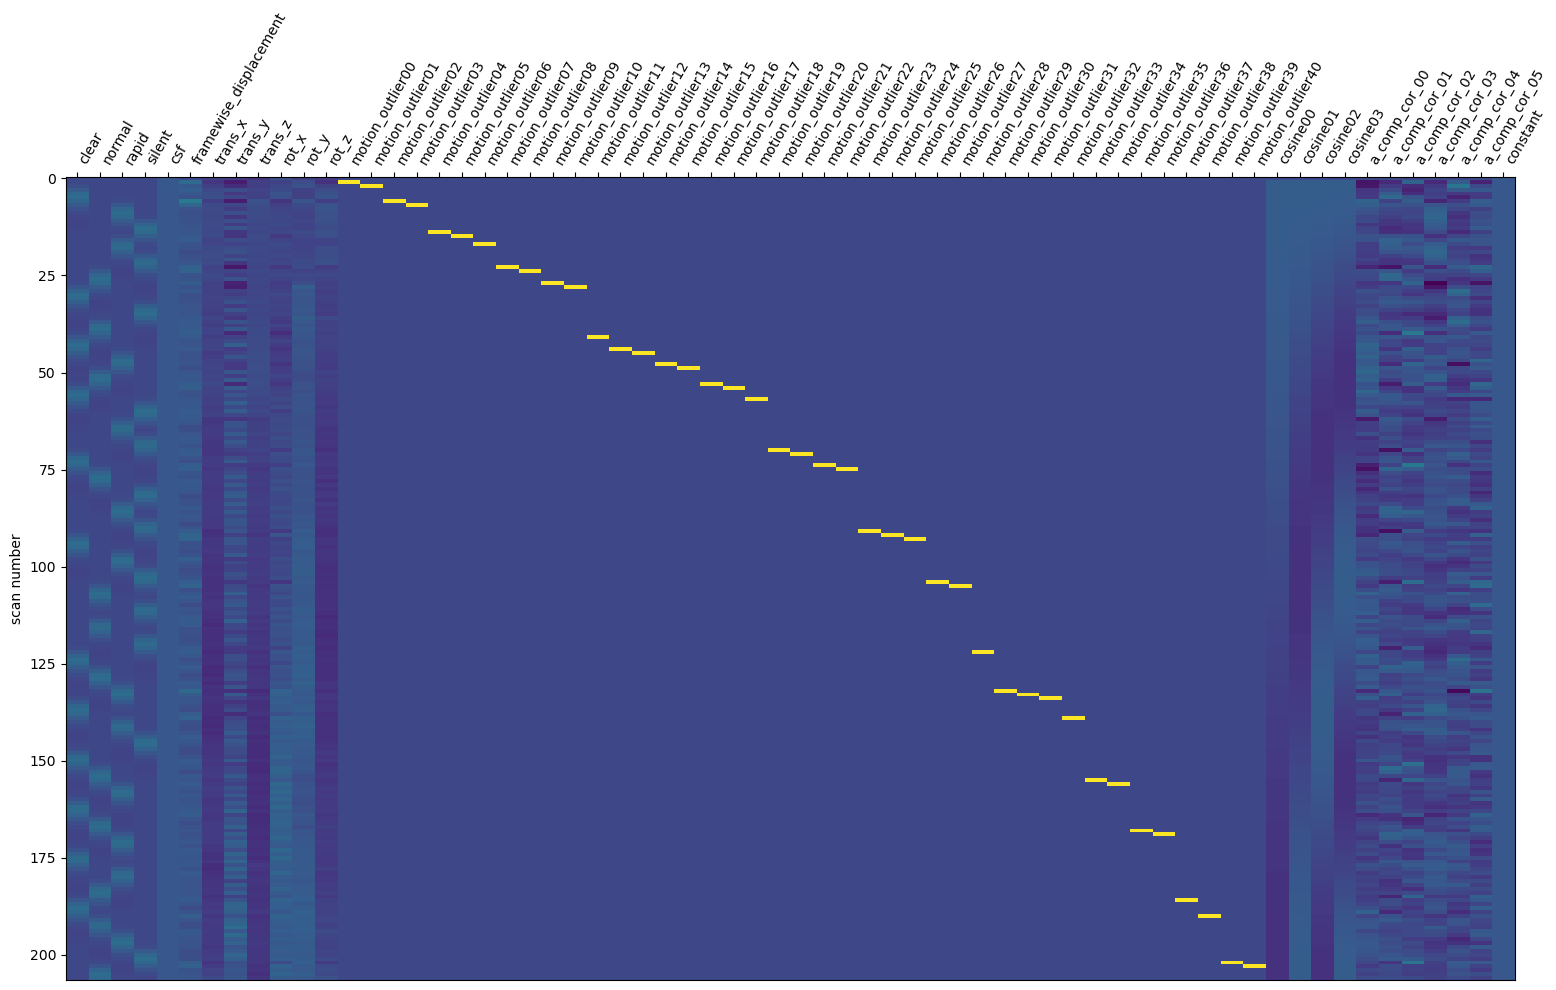

In [120]:
fmri_img = concat_imgs(images)
mean_img = mean_img(fmri_img)

events = counts[0].drop(columns=['subj', 'ses', 'task', 'run'])

TR=1.64 #from pataka json file

from nilearn.glm.first_level import FirstLevelModel
fmri_glm = FirstLevelModel(t_r=TR,
                           noise_model='ar1',
                           drift_model=None,
                           standardize=False,
                           hrf_model='spm',
                           high_pass=.01)

fmri_glm = fmri_glm.fit(fmri_img, events, confounds=selected_confounds)

design_matrix = fmri_glm.design_matrices_[0]

#design_matrix = design_matrix.iloc[0:48]

plot_design_matrix(design_matrix)
plt.show()

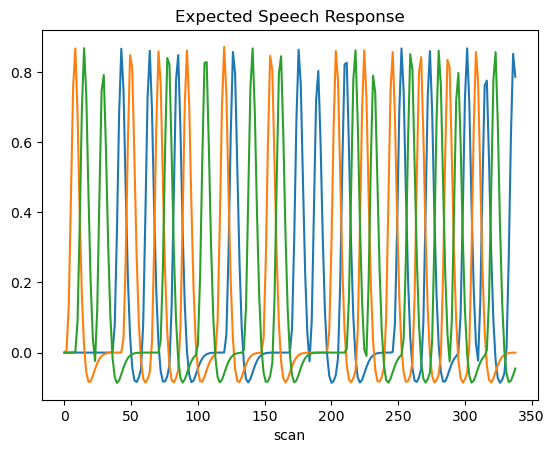

In [126]:
plt.plot(design_matrix[['normal', 'clear', 'rapid']])
plt.xlabel('scan')
plt.title('Expected Speech Response')
plt.show()

<AxesSubplot:label='conditions'>

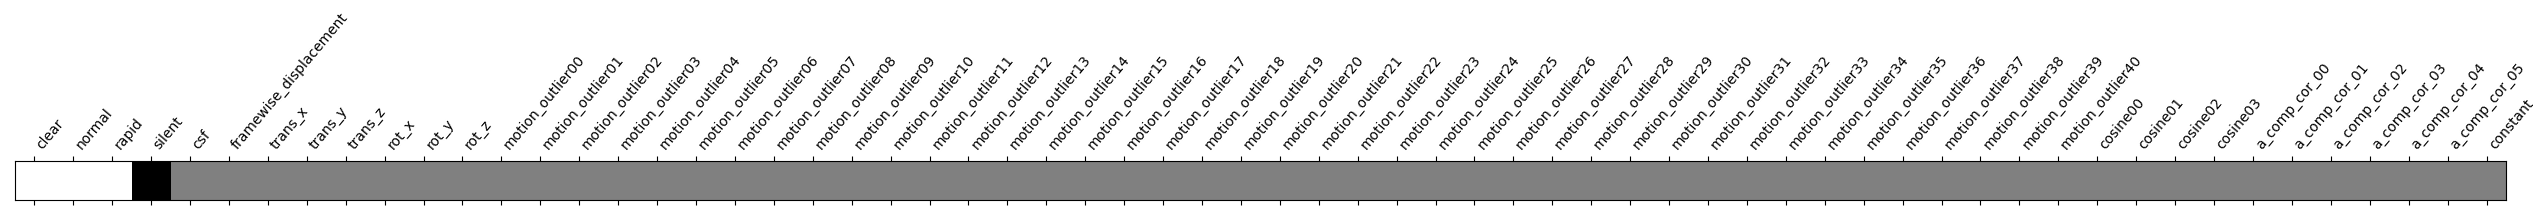

In [122]:
clear = np.zeros(design_matrix.shape[1])
clear[0] = 1
normal = np.zeros(design_matrix.shape[1])
normal[1] = 1
rapid = np.zeros(design_matrix.shape[1])
rapid[2] = 1
silent = np.zeros(design_matrix.shape[1])
silent[3] = 1


conditions = {
    'clear': clear,
    'normal': normal,
    'rapid': rapid,
    'silent': silent
}

active_minus_rest = conditions['clear'] + conditions['normal'] + conditions['rapid'] - conditions['silent']

plot_contrast_matrix(active_minus_rest, design_matrix=design_matrix)

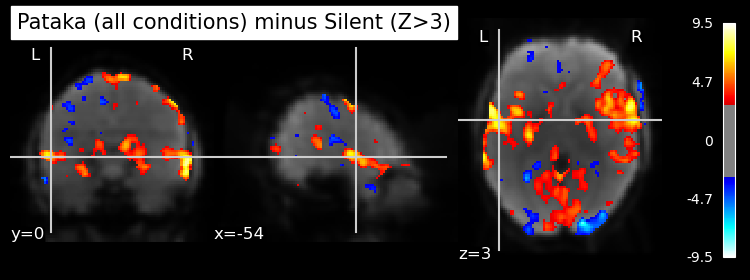

In [123]:
coord = [-54,0,3]

eff_map = fmri_glm.compute_contrast(active_minus_rest,
                                    output_type='effect_size')

z_map = fmri_glm.compute_contrast(active_minus_rest,
                                  output_type='z_score')

plot_stat_map(z_map, bg_img=mean_img, threshold=3,
              display_mode='ortho', cut_coords=coord,
              black_bg=True,
              title='Pataka (all conditions) minus Silent (Z>3)')
plt.show()

In [87]:
fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage6')


Dataset created in /Users/rahulbrito/nilearn_data/fsaverage6



Downloaded 5136384 of 7127975 bytes (72.1%,    0.4s remaining) ...done. (3 seconds, 0 min)
Extracting data from /Users/rahulbrito/nilearn_data/fsaverage6/fc4959d35cad1b55c25ac36b1660ae30/download..... done.


/var/folders/fg/c6b2vcrx7wd1530hgxsj7z7w0000gn/T/ipykernel_68182/3669434506.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


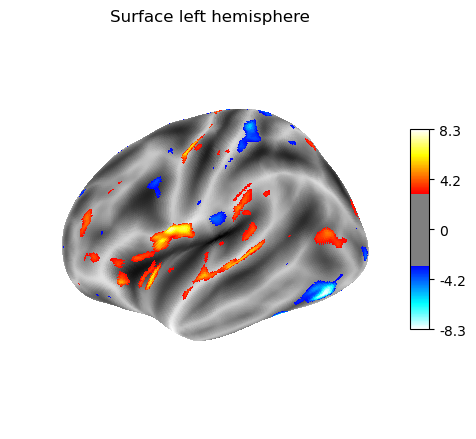

In [124]:
texture = surface.vol_to_surf(z_map, fsaverage.pial_left)

fig = plot_surf_stat_map(
    fsaverage.infl_left, texture, hemi='left',
    title='Surface left hemisphere', colorbar=True,
    threshold=3, bg_map=fsaverage.sulc_left
)
fig.show()

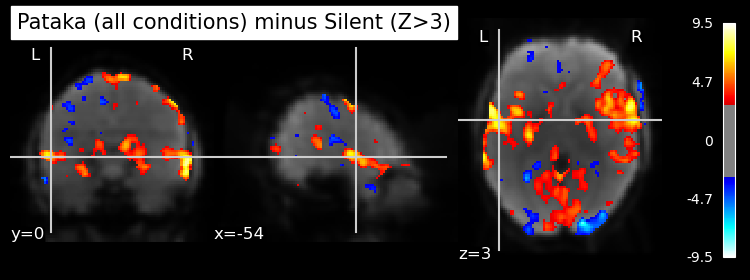

In [110]:
coord = [-54,0,3]

eff_map = fmri_glm.compute_contrast(active_minus_rest,
                                    output_type='effect_size')

z_map = fmri_glm.compute_contrast(active_minus_rest,
                                  output_type='z_score')

plot_stat_map(z_map, bg_img=mean_img, threshold=3,
              display_mode='ortho', cut_coords=coord,
              black_bg=True,
              title='Pataka (all conditions) minus Silent (Z>3)')
plt.show()

Bonferroni-corrected, p<0.005 threshold: 5.587


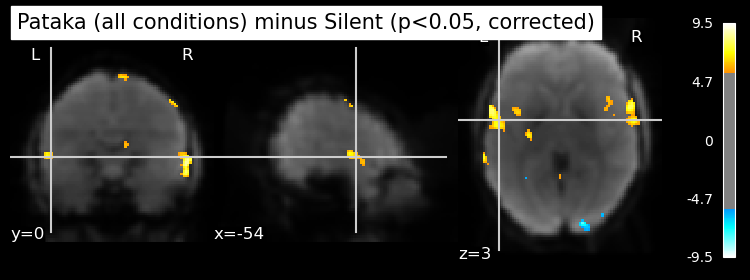

In [59]:
_, threshold = threshold_stats_img(
    z_map, alpha=.005, height_control='bonferroni')
print('Bonferroni-corrected, p<0.005 threshold: %.3f' % threshold)
plot_stat_map(z_map, bg_img=mean_img, threshold=threshold,
              display_mode='ortho', cut_coords=coord, black_bg=True,
              title='Pataka (all conditions) minus Silent (p<0.05, corrected)')
plt.show()

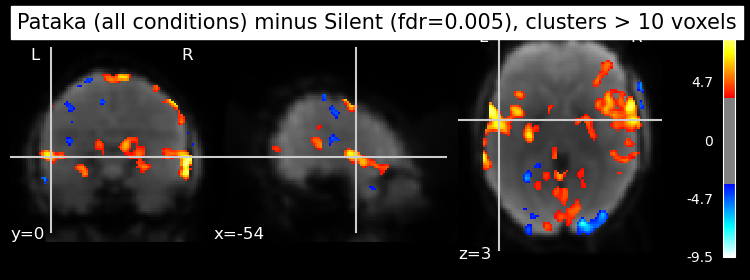

In [58]:
clean_map, threshold = threshold_stats_img(
    z_map, alpha=.005, height_control='fdr', cluster_threshold=10)
plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode='ortho', cut_coords=coord, black_bg=True,
              title='Pataka (all conditions) minus Silent (fdr=0.005), clusters > 10 voxels')
plt.show()

In [88]:
from nilearn.reporting import get_clusters_table
table = get_clusters_table(z_map, stat_threshold=threshold,
                           cluster_threshold=20)
table

/Users/rahulbrito/.local/lib/python3.10/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 4.693166631962805. But, you have given threshold=inf 
  warnings.warn("The given float value must not exceed {0}. "
/Users/rahulbrito/.local/lib/python3.10/site-packages/nilearn/reporting/_get_clusters_table.py:311: UserWarning: Attention: No clusters with stat higher than inf
  warnings.warn(


,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)


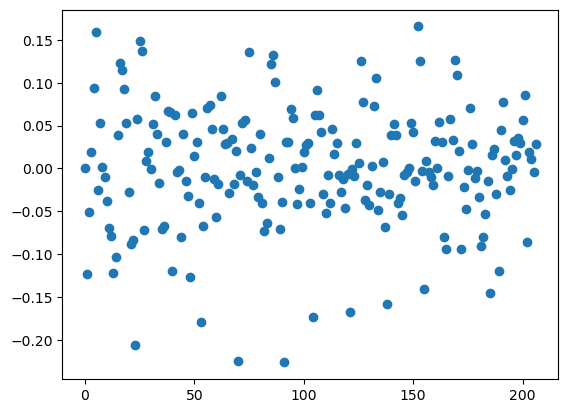

In [38]:
con = pd.read_table('../data/sub-voice994/ses-1/func/sub-voice994_ses-1_task-pataka_run-1_desc-confounds_timeseries.tsv')
plt.scatter(con.index, con.a_comp_cor_01)

In [39]:
con.columns

Index(['global_signal', 'global_signal_derivative1',
       'global_signal_derivative1_power2', 'global_signal_power2', 'csf',
       'csf_derivative1', 'csf_derivative1_power2', 'csf_power2',
       'white_matter', 'white_matter_derivative1',
       ...
       'motion_outlier31', 'motion_outlier32', 'motion_outlier33',
       'motion_outlier34', 'motion_outlier35', 'motion_outlier36',
       'motion_outlier37', 'motion_outlier38', 'motion_outlier39',
       'motion_outlier40'],
      dtype='object', length=178)

In [34]:
con

,global_signal,global_signal_derivative1,global_signal_derivative1_power2,global_signal_power2,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,...,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38,motion_outlier39,motion_outlier40
0,603.430108,NaN,NaN,364127.895258,522.417449,NaN,NaN,272919.990647,547.298390,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,595.900434,-7.529674,56.695997,355097.326711,505.546803,-16.870645,284.618670,255577.570448,544.693117,-2.605273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,598.903146,3.002712,9.016280,358684.977846,502.943810,-2.602993,6.775573,252952.476405,545.019888,0.326771,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,601.490268,2.587123,6.693205,361790.543049,502.357988,-0.585822,0.343188,252363.548085,545.780973,0.761084,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,600.279964,-1.210304,1.464837,360336.035246,500.603013,-1.754975,3.079938,250603.376318,545.977157,0.196184,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,591.791724,0.056743,0.003220,350217.445166,491.438419,-2.288034,5.235098,241511.719327,544.954159,-0.407679,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
203,593.497142,1.705418,2.908449,352238.857723,494.290281,2.851862,8.133116,244322.881470,544.915778,-0.038382,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
204,594.001988,0.504846,0.254870,352838.362027,494.229174,-0.061107,0.003734,244262.476324,545.258572,0.342794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205,593.520354,-0.481635,0.231972,352266.410067,495.589556,1.360382,1.850640,245609.008031,544.937476,-0.321096,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
